In [33]:
# This notebook explores some of the math used for generating SVM signals. It's taken from ST app
# note AN2154 on applying SVM to an 8-bit microcontroller and extended slightly to operate on a
# more modern 32-bit MCU with a 32-bit timer. AppNote AVR32710 also has quite a bit of influence.
# It explores generation of the timing signals for sector 0 only, as a playground for myself to
# understand the math and get a feeling for what influences it.

# Later on in some of the cells, I start simulating the SVM signals presented in:
# https://www.switchcraft.org/learning/2017/3/15/space-vector-pwm-intro

In [34]:
import math
import numpy as np

In [35]:
# *******************************************************************************
# Various constants and parameters
# *******************************************************************************
# Power Supply Voltage
vSupply = 12.0

# Sampling frequency (Hz). I think this is the overflow rate of the timer, or maybe the time it
# takes to complete a full up/down count cycle?
Fs = 10000.0

# Elapsed time per counter tick
timer_freq = 60000000.0  # 60 Mhz
tp = 1/timer_freq

# Equation 17: PWM periods
T = 1.0/Fs
T_half = T/2.0

# Timer max value before count down. Divide by two because we have to make two trips before the PWM cycle completes.
tmax = int((timer_freq / Fs) / 2)

# Reference Vectors. This assumes the most significant bit is Phase W and the least significant bit is Phase U.
# This is following the notation used in Figure 2 of AN2154.
V0 = '000' # Null vector, all low side switches enabled
V1 = '001'
V2 = '011'
V3 = '010'
V4 = '110'
V5 = '100'
V6 = '101'
V7 = '111' # Null vector, all high side switches enabled

# Sector X Optimal Transition Sequence (least # of gates switching)
sector_x_transition_seq = [
  [V0, V0, V0, V0, V0, V0, V0], # Sector 0
  [V0, V1, V2, V7, V2, V1, V0], # Sector 1
  [V0, V3, V2, V7, V2, V3, V0], # Sector 2
  [V0, V3, V4, V7, V4, V3, V0], # Sector 3
  [V0, V5, V4, V7, V4, V5, V0], # Sector 4
  [V0, V5, V6, V7, V6, V5, V0], # Sector 5
  [V0, V1, V6, V7, V6, V1, V0], # Sector 6
  [V7, V7, V7, V7, V7, V7, V7]  # Sector 7
]

# Some constants
pi_div_3 = math.pi/3.0
sqrt_3 = math.sqrt(3.0)

# Indices for the phase vectors
PHASE_U_IDX = 0
PHASE_V_IDX = 1
PHASE_W_IDX = 2

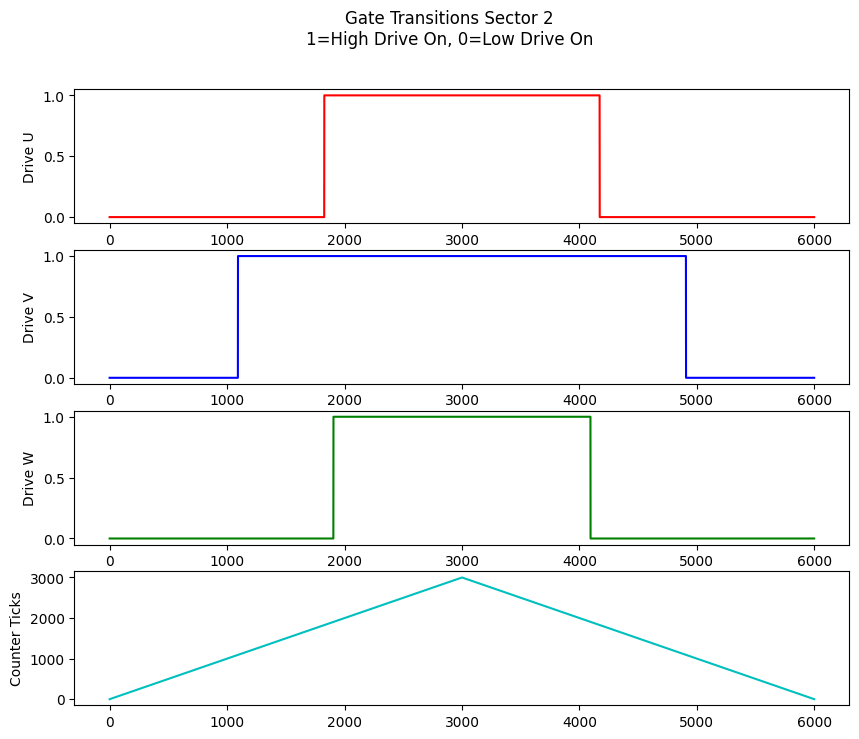

Switch State Transitions:	['000', '010', '011', '111', '011', '010', '000']
Expected Transitions:		['000', '010', '011', '111', '011', '010', '000']


In [68]:
# *******************************************************************************
# User Inputs
# *******************************************************************************
test_angle_rad = 2.00756741
target_sector = 2
sector_offset_deg = 1.0

if test_angle_rad is not None:
  target_sector = math.floor(test_angle_rad / pi_div_3) + 1
  sector_offset_deg = math.degrees(test_angle_rad - ((target_sector-1) * pi_div_3))

assert 1 <= target_sector <= 6, "Invalid sector input"
assert 0.0 <= sector_offset_deg < math.degrees(pi_div_3), "Invalid sector offset"

# Drive strength (modulation index)
mi = 0.299
assert mi <= sqrt_3/2.0, "Modulation index too high"

# *******************************************************************************
# Derived values from user inputs
# *******************************************************************************
sector_offset_rad = math.radians(sector_offset_deg)
sector_start_rad = (target_sector - 1) * pi_div_3

rotor_theta_elec = sector_start_rad + sector_offset_rad

sector = target_sector


# *******************************************************************************
# Compute the PWM timing signals
# https://github.com/m31L3r/STM32F4_SVPWM/blob/master/src/svpwm.c
#
# U,V,W notations are a little different so that they match the descriptions from
# https://www.switchcraft.org/learning/2017/3/15/space-vector-pwm-intro
# *******************************************************************************
# Calculate total time in each vector, which is independent of the sector
ta = T_half * mi * math.sin(pi_div_3-sector_offset_rad) # Time spent in vector A
tb = T_half * mi * math.sin(sector_offset_rad)          # Time spent in vector B
tn = T_half - ta - tb                                   # Time spent in null vector
tn_half = tn/2.0                                        # Time spent in null vector, half cycle

# Compute the capture compare values to generate a particular timing sequence
ton_tn_half = int(tn_half * timer_freq)
ton_1 = int((tn_half + ta) * timer_freq)
ton_2 = int((tn_half + tb) * timer_freq)
ton_3 = int((tn_half + ta + tb) * timer_freq)

if sector == 1:
  phase_u_cc = ton_tn_half
  phase_v_cc = ton_1
  phase_w_cc = ton_3
elif sector == 2:
  phase_u_cc = ton_2
  phase_v_cc = ton_tn_half
  phase_w_cc = ton_3
elif sector == 3:
  phase_u_cc = ton_3
  phase_v_cc = ton_tn_half
  phase_w_cc = ton_1
elif sector == 4:
  phase_u_cc = ton_3
  phase_v_cc = ton_2
  phase_w_cc = ton_tn_half
elif sector == 5:
  phase_u_cc = ton_1
  phase_v_cc = ton_3
  phase_w_cc = ton_tn_half
elif sector == 6:
  phase_u_cc = ton_tn_half
  phase_v_cc = ton_3
  phase_w_cc = ton_2


# *******************************************************************************
# Generate the PWM signals and plot them for visual inspection
# *******************************************************************************
pwm_signals = np.ones((3, 2*tmax), dtype=np.uint32)
ticks = np.zeros((1, 2*tmax), dtype=np.uint32)
tick_values = np.zeros((1, 2*tmax), dtype=np.uint32)

tick = 0
count_up = True
for x in range(2*tmax):
    ticks[0, x] = x
    tick_values[0, x] = tick
    if tick < phase_u_cc:
        pwm_signals[PHASE_U_IDX, x] = 0
    if tick < phase_v_cc:
        pwm_signals[PHASE_V_IDX, x] = 0
    if tick < phase_w_cc:
        pwm_signals[PHASE_W_IDX, x] = 0

    if count_up:
        tick += 1
        count_up = tick < tmax
    else:
        tick -= 1
        count_up = tick == 0

# Plot the PWM signals
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))  # Set the figure size to 10x8 inches
fig.suptitle(f'Gate Transitions Sector {sector}\n1=High Drive On, 0=Low Drive On')

# Create subplot 1
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(ticks[0, :], pwm_signals[PHASE_U_IDX, :], 'r')
ax1.set_ylabel('Drive U')

# Create subplot 2
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(ticks[0, :], pwm_signals[PHASE_V_IDX, :], 'b')
ax2.set_ylabel('Drive V')

# Create subplot 3
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(ticks[0, :], pwm_signals[PHASE_W_IDX, :], 'g')
ax3.set_ylabel('Drive W')

# Create subplot 4
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(ticks[0, :], tick_values[0, :], 'c')
ax4.set_ylabel('Counter Ticks')

plt.show()

# *******************************************************************************
# Validate the PWM signals for accuracy
# *******************************************************************************
# Compute the switch state transitions within the single PWM cycle
binary_values = []

# Iterate over each column
for i in range(pwm_signals.shape[1]):
  # Convert the column to a binary string and then to an integer
  binary_value = ''.join([str(pwm_signals[PHASE_W_IDX, i]), str(pwm_signals[PHASE_V_IDX, i]), str(pwm_signals[PHASE_U_IDX, i])])
  binary_values.append(binary_value)

# Convert the list to a numpy array
binary_values = np.array(binary_values)

# Accumulate the sequence of transitions and the number of ticks in each state
unique_transitions = []
ticks_in_state_x = {}

for i in range(len(binary_values)):
  # If this is the first transition or the transition is different from the previous one, add it to the list
  if i == 0 or binary_values[i] != binary_values[i-1]:
    unique_transitions.append(binary_values[i])

  # If this is the first time we've seen this transition, add it to the dictionary
  if binary_values[i] not in ticks_in_state_x:
    ticks_in_state_x[binary_values[i]] = 1
  else:
    ticks_in_state_x[binary_values[i]] += 1


print(f"Switch State Transitions:\t{unique_transitions}")
print(f"Expected Transitions:\t\t{sector_x_transition_seq[sector]}")
if sector_x_transition_seq[sector] != unique_transitions:
  print(f"ERROR: Transitions do not match expected sequence for sector {sector}")

# Check if only a single bit has changed between each transition
for i in range(len(unique_transitions)-1):
  if bin(int(unique_transitions[i], 2) ^ int(unique_transitions[i+1], 2)).count('1') != 1:
    print(f"ERROR: Invalid transition from {i-1} to {i}")

In [69]:
# Some Notes:
#  This cell is a bit of a mess because I'm experimenting with different timing strategies, trying to find
#  a reliable way to trigger the ADC for sampling currents. The problem with the approach in this cell is
#  that at low sector angle offsets, I don't have enough margin to allow the ADC sampling to complete. I
#  attempted to always meausre while 1 high side switch was on, and 2 low side switches were on, but this
#  didn't really pan out.

# *******************************************************************************
# ADC Sampling Parameters
# *******************************************************************************
adc_total_sample_time_ns = 999.0
adc_total_sample_ticks = int(adc_total_sample_time_ns * 1e-9 / tp)

# *******************************************************************************
# Configure the dead time between high and low side switches. This will be the
# offset required for the ADC trigger, because there is a real amount of time
# before the low side switch turns on an the ADC can measure the current.
# *******************************************************************************
dead_time_ns = 50.0
dead_time_ticks = int(dead_time_ns * 1e-9 / tp)

# *******************************************************************************
# Compute the ADC trigger time depending on which sector we're in
# *******************************************************************************
if sector == 1:
    assert phase_u_cc <= phase_v_cc                 # Make sure I didn't screw up timing calculations
    adc_tick_window = phase_v_cc - phase_u_cc       # Maximum time the ADC can sample the two low phases
    adc_tick_virtual_start = phase_u_cc             # Idealized time the ADC **could** start sampling
    phase_i_samples = (PHASE_V_IDX, PHASE_W_IDX)    # Which phases to sample to get accurate current measurements
elif sector == 2:
    assert phase_u_cc >= phase_v_cc
    adc_tick_window = phase_u_cc - phase_v_cc
    adc_tick_virtual_start = phase_v_cc
    phase_i_samples = (PHASE_U_IDX, PHASE_W_IDX)
elif sector == 3:
    assert phase_w_cc >= phase_v_cc
    adc_tick_window = phase_w_cc - phase_v_cc
    adc_tick_virtual_start = phase_v_cc
    phase_i_samples = (PHASE_U_IDX, PHASE_W_IDX)
elif sector == 4:
    assert phase_v_cc >= phase_w_cc
    adc_tick_window = phase_v_cc - phase_w_cc
    adc_tick_virtual_start = phase_w_cc
    phase_i_samples = (PHASE_U_IDX, PHASE_V_IDX)
elif sector == 5:
    assert phase_u_cc >= phase_w_cc
    adc_tick_window = phase_u_cc - phase_w_cc
    adc_tick_virtual_start = phase_w_cc
    phase_i_samples = (PHASE_U_IDX, PHASE_V_IDX)
elif sector == 6:
    assert phase_w_cc >= phase_u_cc
    adc_tick_window = phase_w_cc - phase_u_cc
    adc_tick_virtual_start = phase_u_cc
    phase_i_samples = (PHASE_V_IDX, PHASE_W_IDX)

# Dump the raw window size
adc_wdw_time = adc_tick_window * tp
print(f"ADC Absolute Window: {adc_tick_window} ticks, {adc_wdw_time * 1e6} uS")

# Apply the dead time compensation
adc_compensated_start = adc_tick_virtual_start + dead_time_ticks
adc_compensated_wdw = adc_tick_window - dead_time_ticks
adc_compensated_wdw_time = adc_compensated_wdw * tp
print(f"ADC Compensated Window: {adc_compensated_wdw} ticks, {adc_compensated_wdw_time * 1e6} uS")

# Center the ADC trigger in the window, assuming we know the ADC sample time
half_adc_sample_ticks = int(adc_total_sample_ticks / 2)
adc_trigger_tick = adc_compensated_start #+ int(adc_compensated_wdw / 2) - half_adc_sample_ticks
adc_end_tick = adc_trigger_tick + adc_total_sample_ticks
print(f"ADC Sample Ticks: {adc_trigger_tick} to {adc_end_tick}")

# Validate we didn't exceed bounds
# assert adc_trigger_tick >= adc_tick_virtual_start, f"ADC Trigger start too early: {adc_trigger_tick} < {adc_tick_virtual_start}"
# assert adc_end_tick <= adc_tick_virtual_start + adc_tick_window, f"ADC Trigger end too late: {adc_end_tick} > {adc_tick_virtual_start + adc_tick_window}"
# print(f"ADC Headroom Ticks: {(adc_tick_virtual_start + adc_tick_window) - adc_end_tick} ticks")

ADC Absolute Window: 735 ticks, 12.25 uS
ADC Compensated Window: 732 ticks, 12.2 uS
ADC Sample Ticks: 1096 to 1155


In [70]:
# Some Notes:
#   - The ADC trigger polarity matters quite a bit here depending if the sample needs to occur during the timer count down or count up.
#   - The computations in this cell are only valid for sector 1
#   - The trigger approach used here follows UM1052 section 5.2, which hops the ADC trigger around depending on available sampling windows.

# *******************************************************************************
# Computing the ADC Sampling Period (UM1052)
# *******************************************************************************
dt = int(250.0  * 1e-9 / tp) # Dead time in ns
tn = int(2000.0 * 1e-9 / tp) # Duration of the shunt resistor noise due to switching in ns (arbitrary estimate?)
tr = int(5.0    * 1e-9 / tp) # Rise time of the input signal to the ADC (could be computed with solid datasheets/spice modeling)
ts = int(1800.0 * 1e-9 / tp) # Sample + conversion time of all channels in the ADC in ns (computed from MCU datasheet + register settings)

# Time for the waveform to settle after the idealized switch period
tstable = dt + max(tn, tr)

# Validate the hypothesis from pg 62
assert ts < tstable, f"Invalid ADC sampling period: {ts} > {tstable}"

# *******************************************************************************
# Case 1: dDutyA > tstable
#   Samples inside the Phase A low side switch period. Wide amount of space.
# *******************************************************************************
duty_a = phase_u_cc # See figure 54
if duty_a > tstable:
  print("Selecting Case 1")
  # Technically this is sampling immediately after switch A low side turns on, but way before the counter underflows.
  # I think this would mean we are sampling more "peak-ish" currents rather than averages?
  sample_offset = duty_a - tstable
  # TODO: This is highly likely before the counter underflow, meaning a rising edge trigger

# *******************************************************************************
# Case 2: dDutyA < tstable AND dDutyAB < 2 * dDutyA
#  Still sampling inside Phase A low, but towards the end. Narrow amount of space.
# *******************************************************************************
duty_ab = phase_v_cc - phase_u_cc   # See figure 55
if (duty_a < tstable) and (duty_ab < (2 * duty_a)):
  print("Selecting Case 2")
  sample_offset = phase_v_cc - duty_ab - dt - tn  # I think this is the same as Case 1?
  # TODO: Highly likely to be after the counter underflow, meaning a falling edge trigger

# *******************************************************************************
# Case 3: dDutyA < tstable AND dDutyAB > 2 * dDutyA
#  Sampling at end of Phase A high period. Medium amount of space.
# *******************************************************************************
if (duty_a < tstable) and (duty_ab > (2 * duty_a)):
  print("Selecting Case 3")
  sample_offset = phase_v_cc - dt - tr
  # TODO: 100% before the counter underflow, meaning a rising edge trigger

# *******************************************************************************
# Case 4: dDutyA < tstable AND dDutyAB > 2 * dDutyA AND (dDutyAB - (dt + tr)) < 2 * tn + tr
#  Impossible to sample currents. Reduce modulation index, decrease frequency, or accept more noise.
# *******************************************************************************
if (duty_a < tstable) and (duty_ab > (2 * duty_a)) and ((duty_ab - (dt + tr)) < (2 * tn + tr)):
  print("Selecting Case 4: Impossible to sample currents. Reduce modulation index or decrease frequency.")
  sample_offset = -1

assert sample_offset >= 0
print(f"Sample Offset: {sample_offset} ticks")
print(f"Phase U CC: {phase_u_cc}, Phase V CC: {phase_v_cc}, Phase W CC: {phase_w_cc}")

Selecting Case 1
Sample Offset: 1693 ticks
Phase U CC: 1828, Phase V CC: 1093, Phase W CC: 1906


In [71]:
# Now lets generalize the above to work for all sectors. We're going to assuming the same timing characteristics
# but we'll need to adjust the ADC trigger timing references depending on the sector.

# UPDATE: I've discovered that with my current software configuration (10kHz PWM, ~2uS ADC sample, 250nS dead time, ~2uS settling time)
# that I can't actually hit cases 2-4 below. I have too much "overhead" in a good way. I can start hitting more of these cases if I increase
# the PWM frequency to 20kHz, but my software literally can't keep up with cycle by cycle FOC calculations at that speed.

# *******************************************************************************
# Figure out which phases will will be used as a reference
# *******************************************************************************
if sector == 1:
  # https://images.squarespace-cdn.com/content/v1/584729023e00bebf8abd6ba0/1493084456915-RDN7O3Z8G6W0Y35T31P3/SVPWM-1.png?format=2500w
  ref_phase_x_cc = phase_u_cc   # Phase with high side ON the longest time
  ref_phase_y_cc = phase_v_cc   # Phase with with high side ON the 2nd longest time
  measured_currents = (PHASE_U_IDX, PHASE_V_IDX) # Which phases will have valid currents
elif sector == 2:
  # https://images.squarespace-cdn.com/content/v1/584729023e00bebf8abd6ba0/1493084456541-BN3S65DZJ8N4GD717KFM/SVPWM-2.png?format=2500w
  ref_phase_x_cc = phase_v_cc
  ref_phase_y_cc = phase_u_cc
  measured_currents = (PHASE_U_IDX, PHASE_V_IDX)
elif sector == 3:
  # https://images.squarespace-cdn.com/content/v1/584729023e00bebf8abd6ba0/1493084455047-OU07LBQJMGATHTRBEVCX/SVPWM-3.png?format=2500w
  ref_phase_x_cc = phase_v_cc
  ref_phase_y_cc = phase_w_cc
  measured_currents = (PHASE_V_IDX, PHASE_W_IDX)
elif sector == 4:
  # https://images.squarespace-cdn.com/content/v1/584729023e00bebf8abd6ba0/1493084455616-FECKYZYTOTJVF8WGFHXJ/SVPWM-4.png?format=2500w
  ref_phase_x_cc = phase_w_cc
  ref_phase_y_cc = phase_v_cc
  measured_currents = (PHASE_V_IDX, PHASE_W_IDX)
elif sector == 5:
  # https://images.squarespace-cdn.com/content/v1/584729023e00bebf8abd6ba0/1493084456140-RLOKTO61DTIPE5LC6U7D/SVPWM-5.png?format=2500w
  ref_phase_x_cc = phase_w_cc
  ref_phase_y_cc = phase_u_cc
  measured_currents = (PHASE_U_IDX, PHASE_W_IDX)
elif sector == 6:
  # https://images.squarespace-cdn.com/content/v1/584729023e00bebf8abd6ba0/1493084457375-F597Q58SXQY8X5ORHHTL/SVPWM-6.png?format=2500w
  ref_phase_x_cc = phase_u_cc
  ref_phase_y_cc = phase_w_cc
  measured_currents = (PHASE_U_IDX, PHASE_W_IDX)


# *******************************************************************************
# Computing the ADC Sampling Period -- Generalized Version
# *******************************************************************************
assert ref_phase_y_cc >= ref_phase_x_cc, f"Invalid phase timing: {ref_phase_y_cc} < {ref_phase_x_cc}"

# Case 1
duty_a = ref_phase_x_cc
if duty_a >= tstable:
  print("Selecting Case 1")
  sample_offset = duty_a - tstable
else:
  # Case 2
  duty_ab = ref_phase_y_cc - ref_phase_x_cc
  if duty_ab < (2 * duty_a):
    print("Selecting Case 2")
    sample_offset = ref_phase_y_cc - duty_ab - dt - tn

  # Case 3
  if duty_ab > (2 * duty_a):
    print("Selecting Case 3")
    sample_offset = ref_phase_y_cc - dt - tr

  # Case 4
  if (duty_a < tstable) and (duty_ab > (2 * duty_a)) and ((duty_ab - (dt + tr)) < (2 * tn + tr)):
    print("Selecting Case 4: Impossible to sample currents. Reduce modulation index or decrease frequency.")
    sample_offset = -1

assert sample_offset >= 0
print(f"Sample Offset: {sample_offset} ticks")
print(f"Phase U CC: {phase_u_cc}, Phase V CC: {phase_v_cc}, Phase W CC: {phase_w_cc}")

Selecting Case 1
Sample Offset: 958 ticks
Phase U CC: 1828, Phase V CC: 1093, Phase W CC: 1906
